In [1]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import factorized

import matplotlib.pyplot as plt

# Anisotropic diffusion (no approximation) using the implicit BTCS scheme
### Anisotropic diffusion - Modified 
In this notebook, we will implement the Forward-Time Central-Space (FTCS) discretization of the anisotropic diffusion equation in the slowly varying approximation. The anisotropic diffusion equation describes the diffusion of a species in a medium where the diffusion rate depends on the direction of diffusion. The equation can be written as:
$$ \frac{\partial \rho}{\partial t} = \nabla \cdot (D \nabla \rho)$$
where $\rho$ is the density of the diffusing species and $D$ is the diffusion tensor

In two dimensions, the anisotropic diffusion tensor can be represented in Cartesian coordinates as a positive-definite symmetric matrix:

$$ D = \begin{pmatrix} D^{xx} & D^{xy} \\ D^{xy} & D^{yy} \end{pmatrix} $$

Expanding the anisotropic diffusion equation yields:

$$\begin{align} \frac{\partial \rho}{\partial t} &= \frac{\partial}{\partial x}\left(D^{xx}\frac{\partial \rho}{\partial x} + D^{xy}\frac{\partial \rho}{\partial y}\right) + \frac{\partial}{\partial y}\left(D^{xy}\frac{\partial \rho}{\partial x} + D^{yy}\frac{\partial \rho}{\partial y}\right)\\
  & = D^{xx}\frac{\partial^2 \rho}{\partial x^2} + D^{yy}\frac{\partial^2 \rho}{\partial y^2} + 2D^{xy}\frac{\partial^2 \rho}{\partial x \partial y}  + \left(\frac{\partial D^{xx}}{\partial x} + \frac{\partial D^{xy}}{\partial y}\right) \frac{\partial \rho}{\partial x} + \left(\frac{\partial D^{xy}}{\partial x} + \frac{\partial D^{yy}}{\partial y}\right)\frac{\partial \rho}{\partial y} \nonumber\end{align}$$
  
### Implicit BTCS discretization
The implicit Backward-Time Central-Space (BTCS) discretization of the full anisotropic diffusion equation is given by:
  $$\begin{align} \rho_{i,j}^{n+1} &= \rho_{i,j}^n + \Delta t \left( D^{xx}_{i,j}\,\frac{\rho_{i+1,j}^{n+1} - 2\rho_{i,j}^{n+1} + \rho_{i-1,j}^{n+1}}{(\Delta x)^2} + D^{yy}_{i,j}\,\frac{\rho_{i,j+1}^{n+1} - 2\rho_{i,j}^{n+1} + \rho_{i,j-1}^{n+1}}{(\Delta y)^2} + \right. \nonumber \\
  & \quad \left. 2D^{xy}_{i,j}\,\frac{\rho_{i+1,j+1}^{n+1} - \rho_{i+1,j-1}^{n+1} - \rho_{i-1,j+1}^{n+1} + \rho_{i-1,j-1}^{n+1}}{4\Delta x \Delta y} + \right. \nonumber \\
  & \quad \left. \frac{D^{xx}_{i+1,j} - D^{xx}_{i-1,j}}{2\Delta x}\frac{\rho_{i+1,j}^{n+1} - \rho_{i-1,j}^{n+1}}{2\Delta x} + \frac{D^{yy}_{i,j+1} - D^{yy}_{i,j-1}}{2\Delta y}\frac{\rho_{i,j+1}^{n+1} - \rho_{i,j-1}^{n+1}}{2\Delta y} + \right. \nonumber \\
  & \quad \left. \frac{D^{xy}_{i+1,j} - D^{xy}_{i-1,j}}{2\Delta x}\frac{\rho_{i,j+1}^{n+1} - \rho_{i,j-1}^{n+1}}{2\Delta y} + \frac{D^{xy}_{i,j+1} - D^{xy}_{i,j-1}}{2\Delta y}\frac{\rho_{i+1,j}^{n+1} - \rho_{i-1,j}^{n+1}}{2\Delta x} \right)\;,
\end{align}$$

Using index flattening $k = i N_y + j$, we can translate the 2D stencil into a linear system of equations:

$$ A \cdot \vec{\rho}^{n+1} = \vec{\rho}^{n} $$

The matrix $A$ has size $(N_x N_y) \times (N_x N_y)$, where each row corresponds to one flattened grid point $(i,j)$ mapped to index $k = iN_y + j$. Let us define

$$\begin{align} \alpha_x &:= \frac{\Delta t D_{i,j}^{xx}}{(\Delta x)^2} & \alpha_y &:= \frac{\Delta t D_{i,j}^{yy}}{(\Delta y)^2} & \alpha_{xy} &:= \frac{\Delta t D_{i,j}^{xy}}{2\Delta x \Delta y} \end{align}$$

Then, for each grid point $(i,j)$ with flattened index $k = iN_y + j$, the corresponding row in matrix $A$ has these non-zero entries:

- $A_{k,k} = 1 + 2\alpha_x + 2\alpha_y$ (main diagonal)
- $A_{k,k-1} = -\alpha_y$ (`west': coupling to $j-1$, if $j > 0$)
- $A_{k,k+1} = -\alpha_y$ (`east': coupling to $j+1$, if $j < N_y-1$)
- $A_{k,k-N_y} = -\alpha_x$ (`north': coupling to $i-1$, if $i > 0$)
- $A_{k,k+N_y} = -\alpha_x$ (`south': coupling to $i+1$, if $i < N_x-1$)
- $A_{k,k-N_y-1} = -\alpha_{xy}$ (`northwest': coupling to $i-1,j-1$)
- $A_{k,k-N_y+1} = \alpha_{xy}$ (`northeast': coupling to $i-1,j+1$)
- $A_{k,k+N_y-1} = \alpha_{xy}$ (`southwest': coupling to $i+1,j-1$)
- $A_{k,k+N_y+1} = -\alpha_{xy}$ (`southeast': coupling to $i+1,j+1$)


The resulting matrix is sparse with at most 9 non-zero entries per row (for interior points). For points near boundaries, some couplings may not exist or may be replaced by boundary condition expressions.

The following function generates the sparse matrix $A$ using `scipy.sparse.lil_matrix` (a row-based LIst of Lists sparse matrix) and then computes the LU decomposition using the `scipy.sparse.linalg.factorized` function. This function returns a callable that can be used to solve the linear system $A \cdot \vec{\rho}^{n+1} = \vec{\rho}^{n}$ efficiently.

In [2]:

def create_operator( dx, dy, dt, D_xx, D_yy, D_xy, nx, ny):
  """
   Create factorised sparse matrix for full anisotropic diffusion implicit BTCS scheme
  """
  n = nx * ny
  B = lil_matrix((n, n))
  
  # First handle interior points
  for j in range(1, ny-1):
      for i in range(1, nx-1):
          # Current point index
          p = j * nx + i
          
          # Neighbor indices
          p_w = p - 1        # West
          p_e = p + 1        # East
          p_s = p - nx       # South
          p_n = p + nx       # North
          p_sw = p_s - 1     # Southwest
          p_se = p_s + 1     # Southeast
          p_nw = p_n - 1     # Northwest
          p_ne = p_n + 1     # Northeast
          
          # Get diffusion coefficients at this point
          dxx = D_xx[j, i]
          dyy = D_yy[j, i]
          dxy = D_xy[j, i]
          
          # Coefficients for second derivatives
          alpha_x  = dt * dxx / (dx**2)
          alpha_y  = dt * dyy / (dy**2)
          alpha_xy = dt * dxy / (2*dx*dy)  # Note factor of 2 for mixed derivative
          
          # Diagonal term (center)
          B[p, p] = 1 + 2 * alpha_x + 2 * alpha_y
          
          # Off-diagonal terms for second derivatives
          B[p, p_w] = B[p, p_e] = -alpha_x
          B[p, p_s] = B[p, p_n] = -alpha_y
          
          # Terms for mixed derivatives
          B[p, p_sw] = B[p, p_ne] = -alpha_xy
          B[p, p_se] = B[p, p_nw] = alpha_xy

          # Calculate derivatives of diffusion coefficients
          dxx_dx = (D_xx[j, i+1] - D_xx[j, i-1]) / (2*dx)
          dyy_dy = (D_yy[j+1, i] - D_yy[j-1, i]) / (2*dy)
          dxy_dx = (D_xy[j, i+1] - D_xy[j, i-1]) / (2*dx)
          dxy_dy = (D_xy[j+1, i] - D_xy[j-1, i]) / (2*dy)
          
          # Additional terms from spatial derivatives of diffusion tensor
          beta_xx   = dt * dxx_dx / (2*dx)
          beta_yy   = dt * dyy_dy / (2*dy)
          beta_xy_x = dt * dxy_dx / (2*dx)
          beta_xy_y = dt * dxy_dy / (2*dy)
          
          B[p, p_e] -= beta_xx
          B[p, p_w] += beta_xx
          
          B[p, p_n] -= beta_yy
          B[p, p_s] += beta_yy
          
          B[p, p_n] -= beta_xy_x
          B[p, p_s] += beta_xy_x
          
          B[p, p_e] -= beta_xy_y
          B[p, p_w] += beta_xy_y

  # Now handle boundary conditions (Neumann) by embedding in the matrices
  # Bottom boundary (j=0)
  for i in range(1, nx-1):
      p = i 
      p_n = p + nx  # North neighbor
      B[p, p] = 1
      B[p, p_n] = 0
  
  # Top boundary (j=ny-1)
  for i in range(1, nx-1):
      p = (ny-1)*nx + i
      p_s = p - nx  # South neighbor
      B[p, p] = 1
      B[p, p_s] = 0
  
  # Left boundary (i=0)
  for j in range(ny):
      p = j*nx
      p_e = p + 1  # East neighbor
      B[p, p] = 1
      B[p, p_e] = 0
  
  # Right boundary (i=nx-1)
  for j in range(ny):
      p = j*nx + (nx-1)
      p_w = p - 1  # West neighbor
      B[p, p] = 1
      B[p, p_w] = 0

  # Return factorized sparse operator
  return factorized(B)

### Simulation setup
We will use a domain $[0,1]^2$ with zero flux Neumann boundary conditions, which requires using one ghost cell layer on each side of the domain. We set up a diffusion tensor in polar coordinates, where the radial component is strongly suppressed in comparison to the angular component. We then simulate the diffusion of a circular blob.

Image @ step 0000/0020: t=0.00100
Image @ step 0005/0020: t=0.00600
Image @ step 0010/0020: t=0.01100
Image @ step 0015/0020: t=0.01600


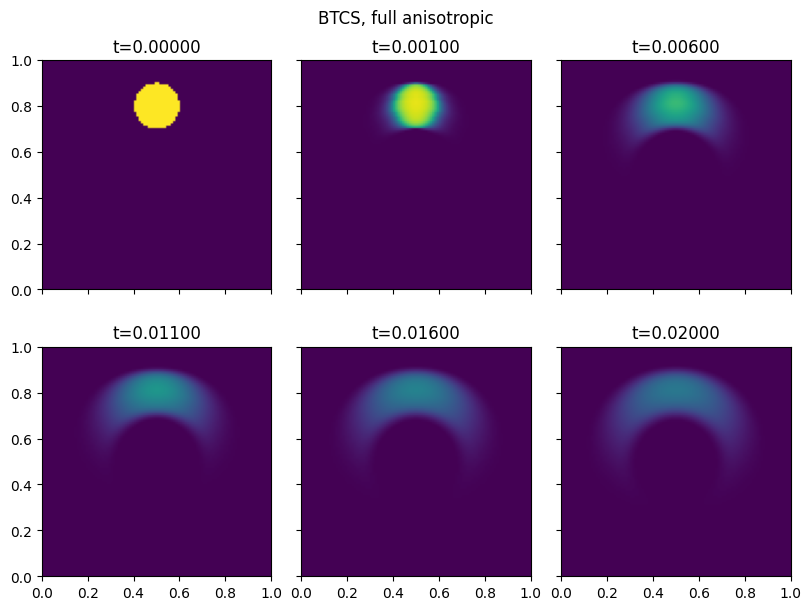

In [4]:
# Parameters
nx, ny = 100, 100  # Grid points
dx, dy = 1.0/(nx-1), 1.0/(ny-1)  # Grid spacing
tmax  = 0.02  # Time step 
steps = 20  # Number of time steps
dt    = tmax / steps

# Create grid
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

# Initial condition: disk with radius 0.1 centered at (0, 0.8)
u = np.zeros((ny, nx))
disk_center = (0.5, 0.8)  # According to the original problem
disk_radius = 0.1

for i in range(nx):
    for j in range(ny):
        if ((X[j,i] - disk_center[0])**2 + (Y[j,i] - disk_center[1])**2) < disk_radius**2:
            u[j,i] = 1.0

# Precompute diffusion tensor components (circular/angular anisotropy)
center_x, center_y = 0.5, 0.5  # Center point for the circular anisotropy

# Diffusion coefficients - avoid zero radial diffusion for numerical stability
D_r = 0.001     # Radial diffusion (small but not zero)
D_theta = 1.0  # Angular diffusion (stronger)

# Calculate relative positions and angles from center
X_rel = X - center_x
Y_rel = Y - center_y
R = np.sqrt(X_rel**2 + Y_rel**2)
# Avoid division by zero at the center point
R = np.where(R < 1e-10, 1e-10, R)
Theta = np.arctan2(Y_rel, X_rel)

# Compute diffusion tensor components in Cartesian coordinates
D_xx = D_r * np.cos(Theta)**2 + D_theta * np.sin(Theta)**2
D_yy = D_r * np.sin(Theta)**2 + D_theta * np.cos(Theta)**2
D_xy = (D_r - D_theta) * np.sin(Theta) * np.cos(Theta)

# Create operators
B_inv_op = create_operator( dx, dy, dt, D_xx, D_yy, D_xy, nx, ny )

# Determine interval for plots
plot_interval = steps//4

# Solve using BTCS
t       = 0.0
frames  = [u.copy()]
frame_t = [t]
u_flat = u.reshape(-1)
for step in range(steps):
    # Solve system: B * u^{n+1} = u^n
    u_new_flat = B_inv_op( u_flat )
    
    # Reshape to 2D
    u_new = u_new_flat.reshape((ny, nx))
    t     = t + dt
    
    # Update solution and flatten
    u = u_new
    u_flat = u.reshape(-1)
    
    if step % plot_interval == 0:
        frames.append(u.copy())
        frame_t.append(t)
        print(f"Image @ step {step:04d}/{steps:04d}: t={t:.5f}")

frames.append(u.copy())
frame_t.append(t)

# Create visualization
n = len(frames)//2
fig, ax = plt.subplots(2,n,figsize=(8, 6),sharex=True,sharey=True, layout='constrained')
plt.suptitle(f'BTCS, full anisotropic')
for i in range(len(frames)):
  a  = ax[i//n,i%n]
  im = a.imshow(frames[i], origin='lower', extent=[0, 1, 0, 1], vmin=0, vmax=1.0)
  a.set_title(f't={frame_t[i]:.5f}')